## Importing the necessary libraries 

In [102]:
## Importing the necessary modules

import os
import warnings
from cryptography.utils import CryptographyDeprecationWarning
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=CryptographyDeprecationWarning)
    import paramiko
from natsort import natsorted
import scipy as sp
import time
import scipy.io as sio
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from skimage.registration import phase_cross_correlation
from skimage.exposure import match_histograms
from scipy.ndimage import shift
import hdf5storage
from multiprocessing import TimeoutError
from multiprocessing.pool import ThreadPool as Pool
from functools import partial
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


## Python function for processing filepaths in Windows

In [103]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")


## Jitter Correction

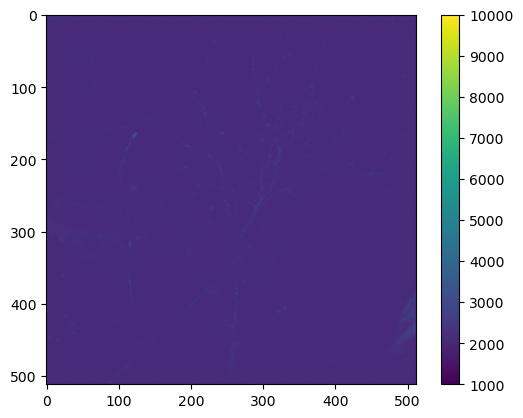

In [105]:
# Load the TIFF stack
data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div16\control_2019_03_24_Cort_CL+enhancerDIV6_timelapse2');
file_name = 'Cort_CL+enhancerDIV6_timelapse2'
stack = tiff.imread(data_folder+'\\'+file_name+'.tif') 
plt.imshow(stack[15],vmin = 1e3, vmax=1e4); plt.colorbar()

(147, 512, 512)


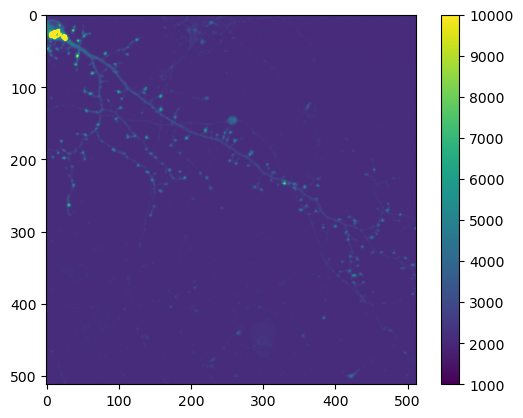

In [72]:
# Delete the frame at a specified index along the first axis
mod_stack = np.delete(stack, 13, axis=0)

# Delete the frame at a specified index along the first axis
mod_stack = np.delete(mod_stack, 14, axis=0)

# Delete the frame at a specified index along the first axis
fin_stack = np.delete(mod_stack, 42, axis=0)

# Check the shape after deletion
print(fin_stack.shape)  # Should be (150, 512, 512)
plt.imshow(fin_stack[13],vmin = 1e3, vmax=1e4); plt.colorbar()

In [106]:
# stack = fin_stack
cumulative_shift_flag = 0     

# Initialize the corrected stack with the same shape and type as the original stack
corrected_stack = np.zeros_like(stack, dtype=np.float32)

# The first frame is assumed to be aligned
corrected_stack[0] = stack[0]

# Initialize the cumulative shift
cumulative_shift = np.array([0.0, 0.0])

# Iterate through each pair of successive frames
for i in tqdm(range(1, len(stack))):
    
    # Specify a background pixel intensity 
    back_intensity = np.median(stack[i])
    
    # Condition for identifying random blips
    if np.max(stack[i]) > 3*back_intensity:
        new_frame = stack[i]
        mask = stack[i] > 2.5*back_intensity  # masking for identifying blip locations
        new_frame[mask] = back_intensity    # replacing those locations with the background intensity
        stack[i] = new_frame
       
    # Compute the shift between the current frame and the first frame
    shift_val, error, diffphase = phase_cross_correlation(stack[0], stack[i],upsample_factor=100)
    
    print (shift_val, error)
    
    # Update the cumulative shift
    cumulative_shift += shift_val

    # Apply the cumulative shift (or instantaneous shift) to align the current frame
    if cumulative_shift_flag == 1:    
        corrected_frame = shift(stack[i], cumulative_shift, order=1, mode='nearest', prefilter=False)
    else:
        corrected_frame = shift(stack[i], shift_val, order=1, mode='nearest', prefilter=False)
    
    # Ensure the corrected frame is of type float32
    corrected_stack[i] = corrected_frame.astype(np.float32)

# Save the corrected stack to a new TIFF file
corrected_tiff_path = data_folder+'\\'+file_name+'_jitter_corrected.tiff'
tiff.imwrite(corrected_tiff_path, corrected_stack)

print(f"Drift correction completed. Corrected stack saved to {corrected_tiff_path}")

  2%|▏         | 3/150 [00:00<00:11, 13.13it/s]

[0.04 0.01] 1.0
[  67.24 -149.21] 1.0
[-0.04 -0.06] 1.0
[ 0.01 -0.06] 1.0


  5%|▍         | 7/150 [00:00<00:09, 15.25it/s]

[-0.12 -0.05] 1.0
[-0.05 -0.12] 1.0
[-0.16 -0.11] 1.0
[-0.09 -0.12] 1.0


  9%|▊         | 13/150 [00:00<00:06, 20.08it/s]

[-0.05 -0.11] 1.0
[-0.11 -0.26] 1.0
[ 0.02 -0.17] 1.0
[-0.09 -0.15] 1.0
[-0.18 -0.17] 1.0


 11%|█         | 16/150 [00:00<00:06, 21.05it/s]

[ 0.   -0.21] 1.0
[-0.13 -0.24] 1.0
[-0.13 -0.23] 1.0
[-0.11 -0.24] 1.0
[-0.21 -0.22] 1.0
[-0.18 -0.3 ] 1.0


 15%|█▍        | 22/150 [00:01<00:05, 21.86it/s]

[-0.24 -0.17] 1.0
[-0.11 -0.26] 1.0
[-0.13 -0.21] 1.0
[-0.08 -0.22] 1.0
[-0.1  -0.28] 1.0


 19%|█▊        | 28/150 [00:01<00:05, 22.82it/s]

[-0.12 -0.32] 1.0
[-0.09 -0.2 ] 1.0
[ 0.02 -0.26] 1.0
[-0.03 -0.2 ] 1.0
[-0.14 -0.18] 1.0


 23%|██▎       | 34/150 [00:01<00:05, 23.16it/s]

[ 0.   -0.26] 1.0
[ 0.  -0.2] 1.0
[-0.05 -0.31] 1.0
[ 0.   -0.26] 1.0
[ 0.   -0.29] 1.0
[ 0.   -0.25] 1.0


 27%|██▋       | 40/150 [00:01<00:04, 23.54it/s]

[-0.07 -0.22] 1.0
[-0.05 -0.27] 1.0
[-0.08 -0.19] 1.0
[-0.07 -0.34] 1.0
[-0.04 -0.25] 1.0


 29%|██▊       | 43/150 [00:02<00:04, 24.10it/s]

[ 0.   -0.25] 1.0
[-0.09 -0.27] 1.0
[-0.11 -0.3 ] 1.0
[ 0.03 -0.28] 1.0
[ 0.05 -0.27] 1.0
[-0.02 -0.26] 1.0


 33%|███▎      | 49/150 [00:02<00:04, 24.32it/s]

[ 0.   -0.26] 1.0
[-0.01 -0.21] 1.0
[-0.03 -0.33] 1.0
[ 0.08 -0.31] 1.0
[-0.02 -0.27] 1.0
[ 0.   -0.28] 1.0


 37%|███▋      | 55/150 [00:02<00:03, 24.40it/s]

[ 0.02 -0.41] 1.0
[-0.17 -0.27] 1.0
[ 0.02 -0.26] 1.0
[-0.07 -0.27] 1.0
[-0.04 -0.28] 1.0


 41%|████      | 61/150 [00:02<00:03, 23.72it/s]

[-0.12 -0.18] 1.0
[-0.06 -0.23] 1.0
[-0.02 -0.27] 1.0
[ 0.   -0.24] 1.0
[-0.06 -0.19] 1.0


 45%|████▍     | 67/150 [00:03<00:03, 23.97it/s]

[-0.05 -0.18] 1.0
[-0.02 -0.1 ] 1.0
[-0.04 -0.22] 1.0
[-0.09 -0.17] 1.0
[-0.07 -0.12] 1.0
[ 0.01 -0.14] 1.0


 49%|████▊     | 73/150 [00:03<00:03, 23.75it/s]

[ 0.07 -0.19] 1.0
[ 0.07 -0.25] 1.0
[-0.03 -0.26] 1.0
[-0.1  -0.25] 1.0
[-0.02 -0.21] 1.0


 51%|█████     | 76/150 [00:03<00:03, 23.84it/s]

[-0.04 -0.27] 1.0
[-0.12 -0.24] 1.0
[-0.16 -0.28] 1.0
[-0.12 -0.24] 1.0
[-0.16 -0.21] 1.0
[-0.07 -0.17] 1.0


 55%|█████▍    | 82/150 [00:03<00:02, 24.10it/s]

[-0.13 -0.26] 1.0
[-0.02 -0.23] 1.0
[-0.17 -0.23] 1.0
[-0.14 -0.2 ] 1.0
[-0.09 -0.11] 1.0
[-0.16 -0.19] 1.0


 59%|█████▊    | 88/150 [00:03<00:02, 24.03it/s]

[-0.2  -0.16] 1.0
[-0.17 -0.12] 1.0
[-0.09 -0.28] 1.0
[-0.1 -0.2] 1.0
[-0.1  -0.18] 1.0


 63%|██████▎   | 94/150 [00:04<00:02, 24.36it/s]

[-0.14 -0.15] 1.0
[-0.06 -0.14] 1.0
[-0.07 -0.16] 1.0
[-0.05 -0.09] 1.0
[ 0.06 -0.11] 1.0
[-0.06 -0.08] 1.0


 67%|██████▋   | 100/150 [00:04<00:02, 24.65it/s]

[ 0.04 -0.11] 1.0
[-0.04 -0.14] 1.0
[ 0.03 -0.08] 1.0
[-0.03 -0.06] 1.0
[-0.02 -0.13] 1.0
[-0.05 -0.2 ] 1.0


 71%|███████   | 106/150 [00:04<00:02, 18.73it/s]

[-0.08 -0.13] 1.0
[ 0.02 -0.18] 1.0
[-0.04 -0.2 ] 1.0
[-0.14 -0.17] 1.0
[-0.02 -0.19] 1.0


 75%|███████▍  | 112/150 [00:05<00:01, 21.17it/s]

[ 0.   -0.18] 1.0
[ 0.05 -0.15] 1.0
[-0.09 -0.18] 1.0
[ 0.02 -0.18] 1.0
[-0.08 -0.2 ] 1.0
[ 0.1  -0.18] 1.0


 79%|███████▊  | 118/150 [00:05<00:01, 22.94it/s]

[-0.03 -0.13] 1.0
[ 0.06 -0.11] 1.0
[-0.02 -0.2 ] 1.0
[-0.09 -0.14] 1.0
[-0.07 -0.18] 1.0
[-0.1  -0.13] 1.0


 83%|████████▎ | 124/150 [00:05<00:01, 23.88it/s]

[ 0.09 -0.19] 1.0
[-0.06 -0.12] 1.0
[-0.01 -0.21] 1.0
[-0.02 -0.24] 1.0
[-0.03 -0.18] 1.0
[-0.02 -0.15] 1.0


 87%|████████▋ | 130/150 [00:05<00:00, 24.45it/s]

[-0.17 -0.14] 1.0
[-0.02 -0.17] 1.0
[-0.12 -0.11] 1.0
[-0.06 -0.15] 1.0
[-0.14 -0.06] 1.0
[-0.05 -0.16] 1.0


 91%|█████████ | 136/150 [00:05<00:00, 24.80it/s]

[-0.11 -0.17] 1.0
[ 0.03 -0.2 ] 1.0
[-0.08 -0.19] 1.0
[-0.12 -0.17] 1.0
[-0.05 -0.17] 1.0
[-0.09 -0.21] 1.0


 95%|█████████▍| 142/150 [00:06<00:00, 24.90it/s]

[-0.06 -0.22] 1.0
[ 0.01 -0.17] 1.0
[-0.19 -0.2 ] 1.0
[-0.21 -0.14] 1.0
[-0.06 -0.19] 1.0
[-0.17 -0.21] 1.0


 99%|█████████▊| 148/150 [00:06<00:00, 25.11it/s]

[-0.04 -0.15] 1.0
[-0.06 -0.1 ] 1.0
[-0.13 -0.19] 1.0
[-0.18 -0.14] 1.0
[-0.09 -0.16] 1.0
[-0.07 -0.23] 1.0


100%|██████████| 150/150 [00:06<00:00, 22.91it/s]


[ 0.05 -0.21] 1.0
Drift correction completed. Corrected stack saved to E:\\Spandan\\2D_Neurons_Paper\\Glass\\div16\\control_2019_03_24_Cort_CL+enhancerDIV6_timelapse2\Cort_CL+enhancerDIV6_timelapse2_jitter_corrected.tiff


## Bleach Correction

In [101]:
# Initialize the corrected stack with the same shape and type as the original stack
bleach_corr_stack = np.zeros_like(stack, dtype=np.float32)

# The first frame is assumed to be the reference (aka bleach corrected already)
bleach_corr_stack[0] = corrected_stack[0]

# Iterate through each pair of successive frames
for i in tqdm(range(1, len(corrected_stack))):
    
    bleach_corr_frame = match_histograms(corrected_stack[i], corrected_stack[0], channel_axis=None)
    
    # Ensure the corrected frame is of type float32
    bleach_corr_stack[i] = bleach_corr_frame.astype(np.float32)

# Save the corrected stack to a new TIFF file
bleach_corr_tiff_path = data_folder+'\\'+file_name+'_jttr_blch_corr.tiff'
tiff.imwrite(bleach_corr_tiff_path, corrected_stack)

print(f"Bleach correction completed. Corrected stack saved to {bleach_corr_tiff_path}")


100%|██████████| 106/106 [00:02<00:00, 43.23it/s]


Bleach correction completed. Corrected stack saved to E:\\Spandan\\2D_Neurons_Paper\\Glass\\div3\MAX_Cortical_6well+CL_B1_488_timelapse1_jttr_blch_corr.tiff


## See how the jitter and bleach corrected movie frames look like


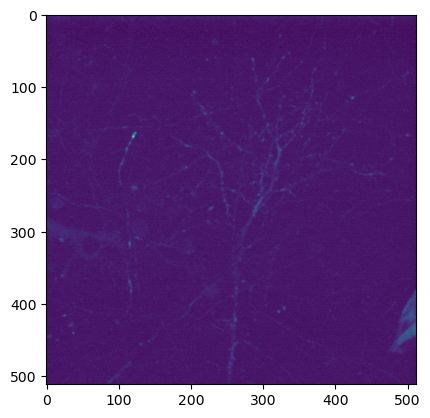

In [111]:
# Weights for temporal smoothing of the frames. Smoothing array-kernel used (by Simoncelli) 
#https://www.cns.nyu.edu/pub/eero/simoncelli94b.pdf

w1 = 0.036; w2 = 0.249; w3 = 0.431;
n_frames = np.shape(bleach_corr_stack)[0];
# np.shape(bleach_corr_stack)
plt.imshow(bleach_corr_stack[0,:,:])   # check out the first frame of the raw movie

## Smoothing of the jitter and bleach corrected timestack

Run time = 0.6430909633636475 s


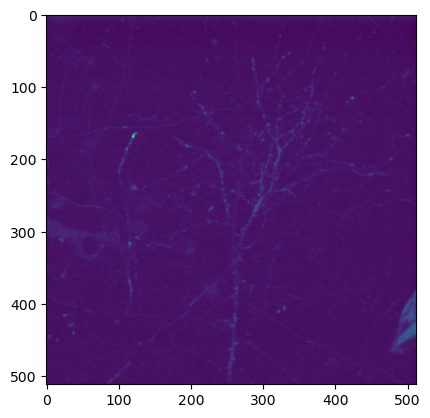

In [112]:
start = time.time()

img = bleach_corr_stack
# smoothing the image frames
smo_im = w1*img[0:-4] + w2*img[1:-3] + w3*img[2:-2] + w2*img[3:-1] + w1*img[4:]
fin_im = np.concatenate((img[0:1],img[1:2],smo_im,img[-2:-1],img[-1:]),axis = 0)   # padding the bordering time-frames

end = time.time(); print('Run time = '+str(end-start)+' s')

plt.imshow(fin_im[5,:,:])    # check any frame of the smoothened movie

## Performing Optical Flow using the smoothed timeframes

In [113]:
# Lucas-Kanade method for Optical Flow
# INPUTS: 

#k: Timeframe index, input_image: temporally smoothed movie
#sig: Spread of the Gaussian weights around a pixel, #thresh: Threshold for reliability score

# OUTPUTS (stored in a data file): 
#vx: x-velocity, vy: y-velocity, reliabMat: reliability score for velocities calculated at a pixel (higher the better)

def LKxOptFlow(k,input_image,sig,thresh):

    img1 = input_image[k]             # Load temporally smoothed frame-1
    img2 = input_image[k+1]         # Load temporally smoothed frame-2
    
    ddy = np.gradient(img1,axis=0,edge_order=2)
    ddx = np.gradient(img1,axis=1,edge_order=2)
    dt = img2 - img1

    ddy = ddy.astype(np.float32); ddx = ddx.astype(np.float32); dt = dt.astype(np.float32); 

    wdx2 = sp.ndimage.gaussian_filter(ddx**2, sig, mode='nearest')
    wdy2 = sp.ndimage.gaussian_filter(ddy**2, sig, mode='nearest')
    wdxy = sp.ndimage.gaussian_filter(ddx*ddy, sig, mode='nearest')
    wdtx = sp.ndimage.gaussian_filter(ddx*dt, sig, mode='nearest')
    wdty = sp.ndimage.gaussian_filter(ddy*dt, sig, mode='nearest')

    trace = wdx2 + wdy2; determinant=(wdx2*wdy2)-(wdxy**2); 
    eps = 1e-6
    
    e1=(trace + np.sqrt(eps + trace**2 - 4*determinant))/2;
    e2=(trace - np.sqrt(eps + trace**2 - 4*determinant))/2;
    reliabMat = np.minimum(e1,e2);
    
    vx = ((determinant + eps)**(-1))*((wdxy*wdty)-(wdy2*wdtx));
    vy = ((determinant + eps)**(-1))*((wdxy*wdtx)-(wdx2*wdty));
    
    vx = vx*(reliabMat > thresh);
    vy = vy*(reliabMat > thresh);
    
    np.savez(save_path+'/{}.npz'.format(k),vx = vx,vy = vy,rel=reliabMat)   # to save as numpy data files
    # sio.savemat(save_path+'\\{}.mat'.format(k),{'vx':vx,'vy':vy,'rel':reliabMat},do_compression=False) # to save as .MAT files
    return [0]


save_path = data_folder+'\\Op_flow'                 # Create a local folder for storing OF results
os.makedirs(save_path, exist_ok=True);

numProcessors = 16   # maybe change it to 8 (but that's it)
pool = Pool(processes=numProcessors)
    
print('Post-processing in parallel with '+str(numProcessors)+' processors')

#store start time
stopwatchStart = time.time()
[temp] =zip(*pool.map(partial(LKxOptFlow, input_image = fin_im, sig = 2, thresh = 0.1), range(n_frames-1)))
  
print('Wall time = '+str(np.round(time.time() - stopwatchStart,2))+' s')

print('Parallel post processing complete, switching to serial')
pool.close()

%reset

Post-processing in parallel with 16 processors
Wall time = 2.26 s
Parallel post processing complete, switching to serial


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Plot Wave Duration (Importing results from MATLAB)

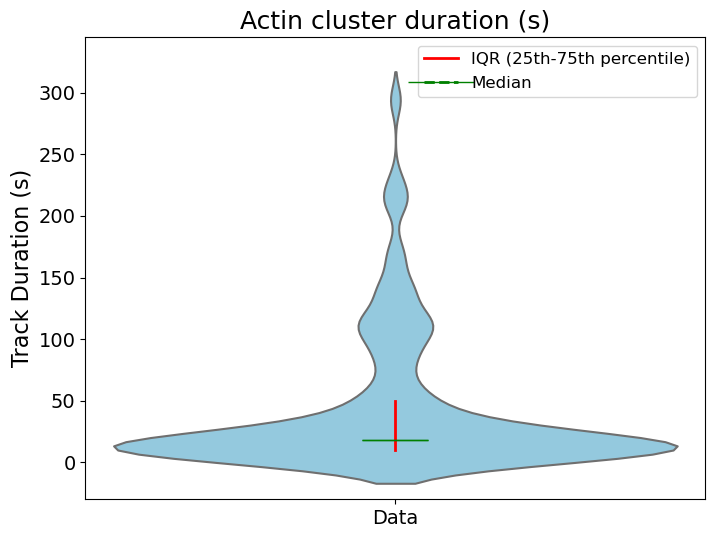

In [109]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import scipy.io as sio


# matr = sio.loadmat('E:\Spandan\Kate_2024\Flat\div2\control_div2_glass_2019_01_23_C1_timelapse1_2secPerTP_5min\duration.mat')
# data = 2.00068*np.array(matr['wv_duration'])

# # Create the violin plot
# plt.figure(figsize=(8, 6))
# sns.violinplot(data=data, inner=None, color="skyblue", bw=0.2)

# # Overlay the scatter points
# # sns.stripplot(data=data, color='k', alpha=0.6, jitter=True)

# # Calculate and plot the median and quartiles
# median = np.median(data)
# q1 = np.percentile(data, 25)
# q3 = np.percentile(data, 75)

# plt.plot([0, 0], [q1, q3], color='red', linewidth=2, label='IQR (25th-75th percentile)')
# plt.plot([0, 0], [median, median], color='green', linewidth=2, linestyle='--', marker='_', markersize=48, label='Median')
# # Customize the plot
# plt.xticks([0], ['Data'], fontsize=14)
# plt.yticks(fontsize=14)
# plt.ylim(-30, 345)
# plt.ylabel('Track Duration (s)',fontsize=16)
# plt.title('Actin cluster duration (s)',fontsize=18)
# plt.legend(fontsize=12)

# # Save the plot as an SVG file
# plt.savefig("violin_plot_duration.svg", format='svg', bbox_inches='tight')

# # Show the plot
# plt.show()
